In [1]:
#%matplotlib inline
import cv2
import warnings
import torch
import matplotlib.pyplot as plt
import numpy as np
from grasp_baseline import config as cfg
from grasp_baseline.dataset import (get_cornell_grasp_ids, get_cornell_id_meta, cornell_grasp_id2realpath,
                    parse_pcl, pc2depth, parse_bbox, normalize_depth, parse_img)
from grasp_baseline.models import GraspModel
from grasp_baseline.utils import (center_crop, crop_image, preprocess_input,feature2bboxwdeg)
from grasp_baseline import inference
from grasp_baseline.utils import visualize
from pydarknet import Detector, Image

In [2]:
import random
import time
random.seed(int(time.time())%20000)
np.random.seed(int(time.time())%20000)

In [3]:
ids = sorted(get_cornell_grasp_ids())
meta, class2id, obj2id = get_cornell_id_meta()

In [4]:
#img_p, pcl_p, pos_p, neg_p = cornell_grasp_id2realpath(ids[np.random.choice(len(ids))])[:4]
#img_p, pcl_p, pos_p, neg_p = cornell_grasp_id2realpath('0325')[:4]

In [5]:
def fetch_by_id(id_):
    img_p, pcl_p, pos_p, neg_p = cornell_grasp_id2realpath(id_)[:4]
    img = parse_img(img_p)
    pts, idx = parse_pcl(pcl_p)
    depth = pc2depth(pts, idx, size=img.shape[:2])
    real_bbox = parse_bbox(pos_p)
    return img, depth, real_bbox

In [6]:
img, depth, real_bbox = fetch_by_id('0400')

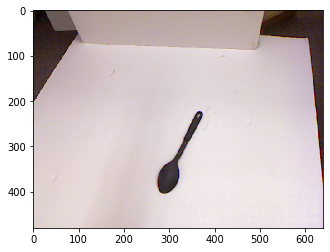

In [7]:
plt.imshow(img)
plt.show()

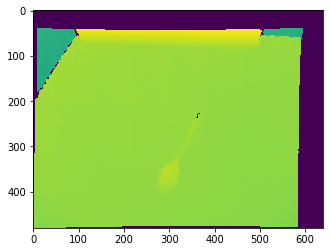

In [8]:
plt.imshow((depth-depth.min()) / (depth.max()-depth.min()))
plt.show()

In [9]:
grasp_detector = inference.GraspDetector()

In [10]:
img2, depth2, real2 = fetch_by_id('0854')
img3, depth3, real3 = fetch_by_id('0350')
img4, depth4, real4 = fetch_by_id('0882')
img6, depth6, real6 = fetch_by_id('0130')
# 1334 x 750
img7 = cv2.resize(parse_img('../Revisiting_Single_Depth_Estimation/IMG_1673.JPG'), (667,375), interpolation=cv2.INTER_AREA)
depth7 = cv2.resize(cv2.imread('../Revisiting_Single_Depth_Estimation/IMG_1673_depth.png', cv2.IMREAD_GRAYSCALE), (667,375), interpolation=cv2.INTER_AREA) # IF DEPTH INFORMATION LOST, WHAT WILL HAPPEND?
img3 = np.roll(img3, 100, axis=1)
depth3 = np.roll(depth3, 100, axis=1)

In [11]:
img_crop = img.copy()[230-150:400+150,300-250:300+150]
d_crop = depth.copy()[230-150:400+150,300-250:300+150]
img5 = np.append(img_crop, np.transpose(img_crop, (1,0,2)), axis=1)
depth5 = np.append(d_crop, d_crop.T, axis=1)
img5 = np.append(img5, img5[::-1], axis=0)
depth5 = np.append(depth5, depth5[::-1], axis=0)

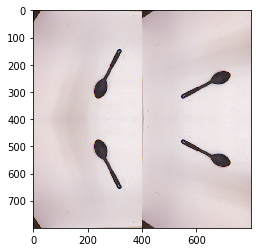

In [12]:
plt.imshow(img5)
plt.show()

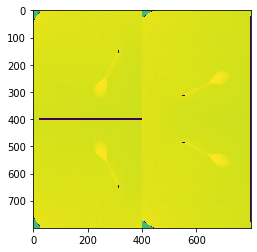

In [13]:
plt.imshow(depth5)
plt.show()

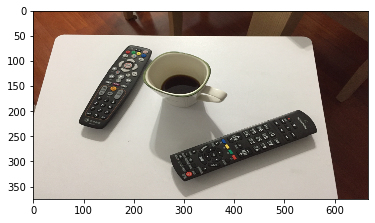

In [14]:
plt.imshow(img7)
plt.show()

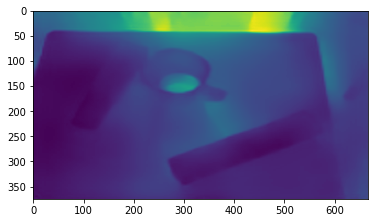

In [15]:
plt.imshow(depth7)
plt.show()

In [16]:
%time bboxes, degs, confs, objs, cats, scores = grasp_detector.detect([img,img2,img3,img4,img5,img6,img7], [depth,depth2,depth3,depth4,depth5,depth6,depth7], -0.3)

CPU times: user 1.62 s, sys: 123 ms, total: 1.74 s
Wall time: 1.72 s


In [17]:
print(bboxes, degs, confs, objs, cats, scores)

[array([[[[341.96216, 229.25049],
         [381.76175, 244.54753],
         [372.91248, 267.5715 ],
         [333.11285, 252.27444]],

        [[333.7517 , 252.0199 ],
         [363.2083 , 267.6373 ],
         [352.28488, 288.2404 ],
         [322.8283 , 272.623  ]],

        [[317.37585, 291.62488],
         [347.26056, 305.9376 ],
         [336.74326, 327.89758],
         [306.85852, 313.58484]],

        [[292.0475 , 315.64032],
         [335.3258 , 329.80768],
         [327.2541 , 354.46518],
         [283.97574, 340.29788]],

        [[275.1125 , 339.21478],
         [333.68127, 368.5341 ],
         [318.58124, 398.69815],
         [260.01248, 369.37885]]]], dtype=float32), array([[[[268.84134, 224.66907],
         [294.7791 , 268.62784],
         [269.79263, 283.37106],
         [243.85483, 239.41232]],

        [[303.40485, 204.55403],
         [320.42578, 264.99542],
         [285.93948, 274.70715],
         [268.91852, 214.26576]],

        [[303.18204, 272.60553],
         [3

In [18]:
print(cats)

[array(['spoon'], dtype='<U17'), array(['plaything'], dtype='<U17'), array(['electronic device'], dtype='<U17'), array(['timepiece'], dtype='<U17'), array(['tableware', 'instrumentality', 'instrumentality', 'spoon'],
      dtype='<U17'), array(['mechanism'], dtype='<U17'), array(['remote control', 'remote control', 'coffee cup'], dtype='<U17')]


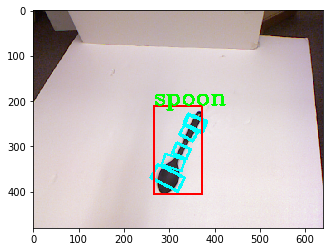

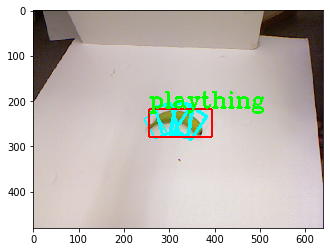

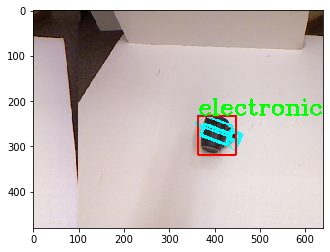

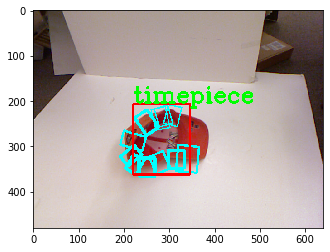

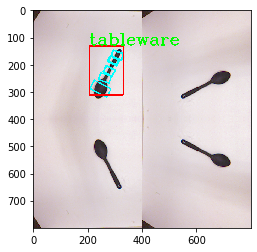

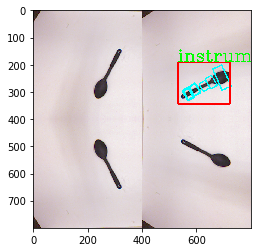

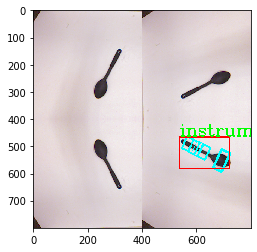

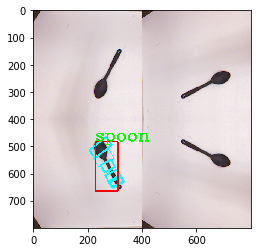

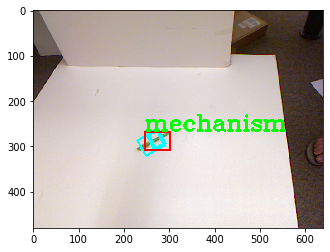

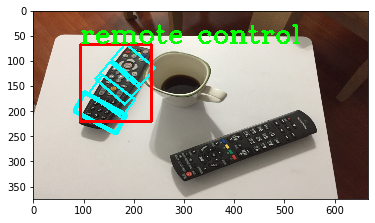

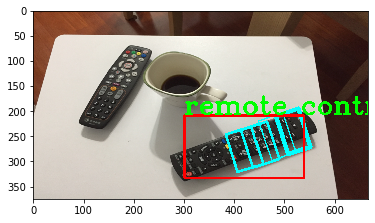

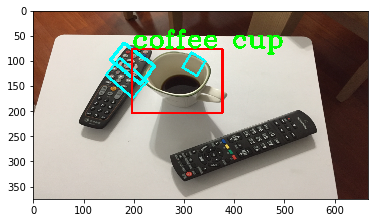

In [19]:
visualize([img,img2,img3,img4,img5,img6,img7], bboxes, confs, objs, cats)